In [1]:
!pip install transformers
!pip install tokenizers
!pip install seqeval
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=a89cabd2c7027618375a99a64f77d7fb2c99e7e87cbe6440fcded5c9b98730e1
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
MAX_LEN = 256
bs = 32

In [3]:
def read_conll_file(file_path):
    data = []
    current_sentence = []
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if line.startswith('-DOCSTART-'):
                continue
            if line:
                parts = line.split()
                word = parts[0]
                ner_label = parts[-1]
                current_sentence.append((word, ner_label))
            else:
                if current_sentence:
                    data.append(current_sentence)
                    current_sentence = []
    if current_sentence:
        data.append(current_sentence)
    return data

In [4]:
train_data = read_conll_file('/content/backtranslated_training.conll')
val_data = read_conll_file('/content/NER_Irish_validation.conll')
test_data = read_conll_file('/content/NER_Irish_test.conll')

In [5]:
# Finding instances of multi-word named entities

def findMWE(sentence):
    tags = [tag for _, tag in sentence]  # Extract only the tags

    # Condition 1: Sentence must contain at least one 'I-' tag
    if not any(tag.startswith('I-') for tag in tags):
        return False

    # Condition 2: Ensure all 'B-' tags are followed by an 'I-' tag
    prev_tag = None
    for tag in tags:
        if tag.startswith('B-'):
            prev_tag = tag  # Store current 'B-' tag
        elif tag.startswith('I-'):
            if prev_tag and prev_tag[2:] == tag[2:]:  # Matching entity type
                prev_tag = None  # Valid sequence, reset

    # If there's still a lingering 'B-' tag, it means it wasn't followed correctly
    return prev_tag is None


mwe_test_data = [sentence for sentence in test_data if findMWE(sentence)]
print(len(mwe_test_data))
print(mwe_test_data[:10])

89
[[('Mar', 'O'), ('a', 'O'), ('tchítear', 'O'), ('do', 'O'), ('Sheosamh', 'B-PER'), ('Mac', 'I-PER'), ('Grianna', 'I-PER'), ('é', 'O'), ('caithfidh', 'O'), ('an', 'O'), ('t-ealaíontóir', 'O'), ('an', 'O'), ('solas', 'O'), ('a', 'O'), ('thabhairt', 'O'), ('don', 'O'), ('saol', 'O'), ('agus', 'O'), ('diúltú', 'O'), ('do', 'O'), ('chathú', 'O'), ('sin', 'O'), ('na', 'O'), ('truaillíochta', 'O'), ('a', 'O'), ('chuireann', 'O'), ('an', 'O'), ('saol', 'O'), ('ina', 'O'), ('chosán', 'O'), ('.', 'O')], [('Grianghraif', 'O'), ('le', 'O'), ('Maidhc', 'B-PER'), ('Ó', 'I-PER'), ('Seachnasaí', 'I-PER'), ('.', 'O')], [('Tagann', 'O'), ('a', 'O'), ('ráiteas', 'O'), ('tar', 'O'), ('éis', 'O'), ('don', 'O'), ('chomhlacht', 'O'), ('a', 'O'), ('rá', 'O'), ('le', 'O'), ('hoibrithe', 'O'), ('an', 'O'), ('iarnróid', 'O'), ('mí', 'O'), ('ó', 'O'), ('shin', 'O'), ('go', 'O'), ('raibh', 'O'), ('sí', 'O'), ('le', 'O'), ('dúnadh', 'O'), (':', 'O'), ("'Chuamar", 'O'), ('ag', 'O'), ('cruinniú', 'O'), ('i', 'O'),

In [6]:
# Import tokenizer and create tag dictionary
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=False)

tag_values = [
        'O',
        'B-PER',
        'I-PER',
        'B-LOC',
        'I-LOC',
        'B-ORG',
        'I-ORG'
]

tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [8]:
# Split the words and labels in the data
def splitWordsAndLabels(data_list):
  sent = []
  labels = []
  for lst in data_list:
    s = []
    l = []
    for words in lst:
      s.append(words[0])
      l.append(words[1])
    sent.append(s)
    labels.append(l)
  return sent, labels

train_sent, train_labels = splitWordsAndLabels(train_data)
val_sent, val_labels = splitWordsAndLabels(val_data)
test_sent, test_labels = splitWordsAndLabels(test_data)
mwe_test_sent, mwe_test_labels = splitWordsAndLabels(mwe_test_data)
print(train_sent[1])
print(train_labels[1])

['Baineann', 'mo', 'cheist', 'le', 'cúrsaí', 'tithíochta', 'i', 'nGaillimh', '-', 'tá', 'sé', 'níos', 'cirte', 'easpa', 'tithíochta', 'i', 'nGaillimh', 'a', 'rá', '-', 'agus', 'an', 'tascfhórsa', 'a', 'bunaíodh', 'breis', 'agus', 'ceithre', 'bliana', 'ó', 'shin']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [9]:
# Tokenize the data and preserve the corresponding labels/tags

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)
    return tokenized_sentence, labels

# Run the splitting function on the training, test, and validation sets
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train_sent, train_labels)
]

val_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(val_sent, val_labels)
]

test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_sent, test_labels)
]

mwe_test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(mwe_test_sent, mwe_test_labels)
]

# Bring the sentences and labels back together after tokenizing
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

val_tokenized_texts = [token_label_pair[0] for token_label_pair in val_tokenized_texts_and_labels]
val_labels = [token_label_pair[1] for token_label_pair in val_tokenized_texts_and_labels]

test_tokenized_texts = [token_label_pair[0] for token_label_pair in test_tokenized_texts_and_labels]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_texts_and_labels]

mwe_test_tokenized_texts = [token_label_pair[0] for token_label_pair in mwe_test_tokenized_texts_and_labels]

print(tokenized_texts[1])
print(labels[1])

['▁Ba', 'in', 'eann', '▁mo', '▁che', 'ist', '▁le', '▁cúrsaí', '▁ti', 'th', 'íochta', '▁i', '▁n', 'Ga', 'ill', 'imh', '▁-', '▁tá', '▁sé', '▁níos', '▁cir', 'te', '▁ea', 'spa', '▁ti', 'th', 'íochta', '▁i', '▁n', 'Ga', 'ill', 'imh', '▁a', '▁rá', '▁-', '▁agus', '▁an', '▁tas', 'cf', 'hó', 'rsa', '▁a', '▁buna', 'íodh', '▁brei', 's', '▁agus', '▁ce', 'ithre', '▁bliana', '▁ó', '▁shin']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [10]:
# Get the input ids for each dataset
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

val_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

mwe_test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in mwe_test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

# Get the tags for each dataset
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

val_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in val_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

mwe_test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in mwe_test_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

# Create attention masks for each dataset
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

val_attention_masks = [[float(i != 0.0) for i in ii] for ii in val_input_ids]

test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]

mwe_test_attention_masks = [[float(i != 0.0) for i in ii] for ii in mwe_test_input_ids]

# Make the inputs, tags, and masks for each dataset into torch tensors
tr_inputs = torch.tensor(input_ids)
tr_tags = torch.tensor(tags)
tr_masks = torch.tensor(attention_masks)

vl_inputs = torch.tensor(val_input_ids)
vl_tags = torch.tensor(val_tags)
vl_masks = torch.tensor(val_attention_masks)

tst_inputs = torch.tensor(test_input_ids)
tst_tags = torch.tensor(test_tags)
tst_masks = torch.tensor(test_attention_masks)

mwe_tst_inputs = torch.tensor(mwe_test_input_ids)
mwe_tst_tags = torch.tensor(mwe_test_tags)
mwe_tst_masks = torch.tensor(mwe_test_attention_masks)

# Create a tensor dataset, sampler and dataloader for each dataset
tr_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(tr_data) # Sample from the training set randomly
train_dataloader = DataLoader(tr_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(vl_inputs, vl_masks, vl_tags)
valid_sampler = SequentialSampler(valid_data) # Sample from the validation set sequentially
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

tst_data = TensorDataset(tst_inputs, tst_masks, tst_tags)
tst_sampler = SequentialSampler(tst_data) # Sample from the test set sequentially
tst_dataloader = DataLoader(tst_data, sampler=tst_sampler, batch_size=bs)

mwe_tst_data = TensorDataset(mwe_tst_inputs, mwe_tst_masks, mwe_tst_tags)
mwe_sampler = SequentialSampler(mwe_tst_data) # Sample from the mwe test set sequentially
mwe_tst_dataloader = DataLoader(mwe_tst_data, sampler=mwe_sampler, batch_size=bs)

In [11]:
# Load the model
model_name = 'xlm-roberta-base' #XLMRoBERTa
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model.cuda();

In [13]:
# Optimising parameters for finetuning the model
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

epochs = 10
max_grad_norm = 1.0

# Total number of training steps = number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# Defining the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
loss_values, validation_loss_values = [], [] # Store the average loss after each epoch for plotting
best_model_state = None # For early stopping
patience = 2 # Patience is 2 epochs
best_val_loss = float('inf')
epochs_without_improvement = 0
best_epoch = 0

for epoch in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training Loop
    # ========================================
    model.train()
    # Reset the loss for this epoch
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # Add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clearing any previously calculated gradients before performing a backward pass
        model.zero_grad()
        # Forward pass
        # This will return the loss (rather than the model output)
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients
        loss.backward()
        # Track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # the validation set

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            # This will return the logits rather than the loss because we have not provided labels
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #val_report = classification_report(valid_tags, pred_tags)
    #print("Epoch {} - Validation Classification Report:".format(epoch))
    #print(val_report)
    if eval_loss < best_val_loss:
      best_val_loss = eval_loss
      best_epoch = epoch
      best_model_state = model.state_dict()
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
          print(f"Validation loss hasn't improved for {patience} epochs. Best model found at epoch {best_epoch}.")
          break

    print("Epoch {} - Training Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch, avg_train_loss, eval_loss))
    print()

# Output the best epoch model
if best_model_state is not None:
    torch.save(best_model_state, "XLMRoBERTa_BT.pt")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.5116313204169274


Epoch:  10%|█         | 1/10 [00:53<08:01, 53.53s/it]

Validation loss: 0.13970589637756348
Validation Accuracy: 0.7949817713918078
Epoch 0 - Training Loss: 0.5116, Validation Loss: 0.1397

Average train loss: 0.12233169432729482


Epoch:  20%|██        | 2/10 [01:48<07:15, 54.49s/it]

Validation loss: 0.11125779338181019
Validation Accuracy: 0.8239330902852241
Epoch 1 - Training Loss: 0.1223, Validation Loss: 0.1113

Average train loss: 0.10165621284395457


Epoch:  30%|███       | 3/10 [02:44<06:25, 55.10s/it]

Validation loss: 0.0941038429737091
Validation Accuracy: 0.8728286510829938
Epoch 2 - Training Loss: 0.1017, Validation Loss: 0.0941

Average train loss: 0.07092012222856284


Epoch:  40%|████      | 4/10 [03:40<05:32, 55.40s/it]

Validation loss: 0.05331672728061676
Validation Accuracy: 0.9013510615483594
Epoch 3 - Training Loss: 0.0709, Validation Loss: 0.0533

Average train loss: 0.04398241876624524


Epoch:  50%|█████     | 5/10 [04:36<04:37, 55.52s/it]

Validation loss: 0.04287065425887704
Validation Accuracy: 0.9358781900064336
Epoch 4 - Training Loss: 0.0440, Validation Loss: 0.0429

Average train loss: 0.03526438907720149


Epoch:  60%|██████    | 6/10 [05:31<03:42, 55.63s/it]

Validation loss: 0.040569684468209743
Validation Accuracy: 0.9405961827149903
Epoch 5 - Training Loss: 0.0353, Validation Loss: 0.0406

Average train loss: 0.02636911957524717


Epoch:  70%|███████   | 7/10 [06:27<02:47, 55.69s/it]

Validation loss: 0.04000047780573368
Validation Accuracy: 0.9397383658588891
Epoch 6 - Training Loss: 0.0264, Validation Loss: 0.0400

Average train loss: 0.02244252567179501


Epoch:  80%|████████  | 8/10 [07:23<01:51, 55.73s/it]

Validation loss: 0.03888132702559233
Validation Accuracy: 0.9414539995710915
Epoch 7 - Training Loss: 0.0224, Validation Loss: 0.0389

Average train loss: 0.01963240816257894


Epoch:  90%|█████████ | 9/10 [08:19<00:55, 55.79s/it]

Validation loss: 0.04110858589410782
Validation Accuracy: 0.9399528200729145
Epoch 8 - Training Loss: 0.0196, Validation Loss: 0.0411

Average train loss: 0.018707259139046074


Epoch:  90%|█████████ | 9/10 [09:15<01:01, 61.68s/it]

Validation loss: 0.04049950651824474
Validation Accuracy: 0.9399528200729145
Validation loss hasn't improved for 2 epochs. Best model found at epoch 7.


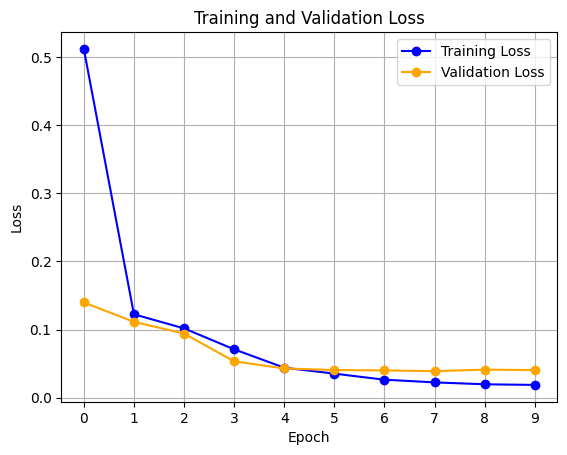

In [15]:
# Training and Validation Loss Plot

# Generate x-axis values (epochs)
epochs = range(len(loss_values) + 1)

# Plotting with markers and lines
plt.plot(epochs[:-1], loss_values, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(epochs[:-1], validation_loss_values, marker='o', linestyle='-', label='Validation Loss', color='orange')

# Labeling and styling
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Set ticks for x-axis (epochs) to whole numbers only starting from 0
plt.xticks(epochs[:-1])


# Ensure y-axis (loss) ticks are whole numbers only
#plt.yticks(range(int(min(min(loss_values), min(validation_loss_values))), int(max(max(loss_values), max(validation_loss_values))) + 1))
plt.savefig('XLMRoBERTa_BT_training_validation_loss_plot.png')
# Show plot
plt.grid(True)
plt.show()

In [16]:
model.eval()

predicted_labels = []
true_labels = []

# Iterate through the test_dataloader to get the predictions
# Using the GPU
for batch in tst_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

    # Disabling gradient calculation for evaluation
    with torch.no_grad():
        outputs = model(**inputs)

    # Extracting the predictions and also the true labels for the test data
    predicted_labels.extend(outputs.logits.argmax(dim=-1).tolist())
    true_labels.extend(inputs['labels'].tolist())

In [17]:
# Checking for issues
i = 0
while i < len(true_labels):
  if len(true_labels[i]) != len(predicted_labels[i]):
    print('issue')
    i += 1
  i += 1

In [18]:
preds = []
trues = []

for sentences in true_labels:
  t = []
  for vals in sentences:
    if vals != 7:
      t.append(vals)
  trues.append(t)

for sentences in predicted_labels:
  p = []
  for vals in sentences:
    if vals != 7:
      p.append(vals)
  preds.append(p)

In [19]:
print(preds)

[[0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 3, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 5, 5, 6, 6, 6, 6, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 6, 6, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
tokenized_labels = []
for sentence, labels in test_tokenized_texts_and_labels:
    tokenized_labels.append(labels)

print(len(tokenized_labels[0]))

52


In [21]:
i = 0
while i < len(tokenized_labels):
  if len(tokenized_labels[i]) != len(preds[i]):
    print('issue', i)
    i += 1
  i += 1

In [22]:
#print(len(tokenized_labels[22]))
#print(len(preds[22]))

In [23]:
#i = 0
#while i < len(tokenized_labels[22]):
#  print(tokenized_labels[22][i], preds[22][i])
#  print()
#  i += 1

In [24]:
#preds[22].insert(0, 0)

In [25]:
label_map = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-LOC',
    4: 'I-LOC',
    5: 'B-ORG',
    6: 'I-ORG'
}

# Initialise an empty list to store DataFrames
dfs = []

# Iterate through the tokens, labels, and predictions
for tokens, labels, predictions in zip(test_tokenized_texts, tokenized_labels, preds):
    # Create a DataFrame from the current sublist
    temp_df = pd.DataFrame({'Word': tokens, 'POS': 'X', 'True': labels, 'Predicted': [label_map[pred] for pred in predictions]})
    # Append the DataFrame to the list
    dfs.append(temp_df)
    # Add an empty row as a DataFrame to the list
    dfs.append(pd.DataFrame({'Word': [''], 'POS': [''], 'True': [''], 'Predicted': ['']}))

# Concatenate the DataFrames along the rows axis
df = pd.concat(dfs, ignore_index=True)

# Print the concatenated DataFrame
print(df)

# Check the alignment is correct
print(df.head(45))

       Word POS   True Predicted
0      ▁Mar   X      O         O
1        ▁a   X      O         O
2        ▁t   X      O         O
3        ch   X      O         O
4     ítear   X      O         O
...     ...  ..    ...       ...
6855  ▁Gael   X  B-LOC         O
6856      t   X  B-LOC         O
6857   acht   X  B-LOC         O
6858   ▁ann   X      O         O
6859                            

[6860 rows x 4 columns]
          Word POS   True Predicted
0         ▁Mar   X      O         O
1           ▁a   X      O         O
2           ▁t   X      O         O
3           ch   X      O         O
4        ítear   X      O         O
5          ▁do   X      O         O
6         ▁She   X  B-PER     B-PER
7           os   X  B-PER     B-PER
8          amh   X  B-PER     B-PER
9         ▁Mac   X  I-PER     I-PER
10        ▁Gri   X  I-PER     I-PER
11        anna   X  I-PER     I-PER
12          ▁é   X      O         O
13         ▁ca   X      O         O
14     ithfidh   X      O         O
15 

In [26]:
# Change to conll format for evaluation script to be run
conll_format = ""

for index, row in df.iterrows():
    text = row['Word']
    pos = row['POS']
    tag = row['True']
    mapped_tag = row['Predicted']

    # Append the token in CoNLL format (word, POS, gold_label, predicted_label)
    conll_format += f"{text}\t{pos}\t{tag}\t{mapped_tag}\n"

# Write the CoNLL format string to a text file
with open('XLMRoBERTa_BT.conll', 'w') as f:
    f.write(conll_format)

#MWE case study

In [27]:
model.eval()

mwe_predicted_labels = []
mwe_true_labels = []

# Iterate through the test_dataloader to get the predictions
# Using the GPU
for batch in mwe_tst_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

    # Disabling gradient calculation for evaluation
    with torch.no_grad():
        outputs = model(**inputs)

    # Extracting the predictions and also the true labels for the test data
    mwe_predicted_labels.extend(outputs.logits.argmax(dim=-1).tolist())
    mwe_true_labels.extend(inputs['labels'].tolist())

In [28]:
#print(mwe_predicted_labels)

In [29]:
print(len(mwe_predicted_labels))
print(len(mwe_true_labels))

89
89


In [30]:
i = 0
while i < len(mwe_true_labels):
  #print(len(mwe_true_labels[i]))
  #print(len(mwe_predicted_labels[i]))
  #print(i)
  if len(mwe_true_labels[i]) != len(mwe_predicted_labels[i]):
    print('issue')
    i += 1
  i += 1

In [31]:
mwe_preds = []
mwe_trues = []

for sentences in mwe_true_labels:
  t = []
  for vals in sentences:
    if vals != 7:
      t.append(vals)
  mwe_trues.append(t)

for sentences in mwe_predicted_labels:
  p = []
  for vals in sentences:
    if vals != 7:
      p.append(vals)
  mwe_preds.append(p)


#print(mwe_test_tokenized_texts_and_labels)
mwe_tokenized_labels = []
for sentence, labels in mwe_test_tokenized_texts_and_labels:
    mwe_tokenized_labels.append(labels)

print(len(mwe_test_tokenized_texts[0]))
print(len(mwe_trues[0]))
print(len(mwe_tokenized_labels[0]))
print(len(mwe_preds[0]))

52
31
52
52


In [32]:
i = 0
while i < len(mwe_tokenized_labels):
  if len(mwe_tokenized_labels[i]) != len(mwe_preds[i]):
    print('issue', i)
    i += 1
  i += 1

In [33]:
# Initialise an empty list to store DataFrames
dfs = []

# Iterate through the tokens, labels, and predictions
for tokens, labels, predictions in zip(mwe_test_tokenized_texts, mwe_tokenized_labels, mwe_preds):
    # Create a DataFrame from the current sublist
    temp_df = pd.DataFrame({'Word': tokens, 'POS': 'X', 'True': labels, 'Predicted': [label_map[pred] for pred in predictions]})
    # Append the DataFrame to the list
    dfs.append(temp_df)
    # Add an empty row as a DataFrame to the list
    dfs.append(pd.DataFrame({'Word': [''], 'POS': [''], 'True': [''], 'Predicted': ['']}))

# Concatenate the DataFrames along the rows axis
df = pd.concat(dfs, ignore_index=True)

# Print the concatenated DataFrame
print(df)

# Check the alignment is correct
print(df.head(45))

       Word POS   True Predicted
0      ▁Mar   X      O         O
1        ▁a   X      O         O
2        ▁t   X      O         O
3        ch   X      O         O
4     ítear   X      O         O
...     ...  ..    ...       ...
4450    éis   X  I-LOC     I-LOC
4451      e   X  I-LOC     I-LOC
4452      ▁   X      O         O
4453      .   X      O         O
4454                            

[4455 rows x 4 columns]
          Word POS   True Predicted
0         ▁Mar   X      O         O
1           ▁a   X      O         O
2           ▁t   X      O         O
3           ch   X      O         O
4        ítear   X      O         O
5          ▁do   X      O         O
6         ▁She   X  B-PER     B-PER
7           os   X  B-PER     B-PER
8          amh   X  B-PER     B-PER
9         ▁Mac   X  I-PER     I-PER
10        ▁Gri   X  I-PER     I-PER
11        anna   X  I-PER     I-PER
12          ▁é   X      O         O
13         ▁ca   X      O         O
14     ithfidh   X      O         O
15 

In [34]:
# Change to conll format for evaluation script to be run
conll_format = ""

for index, row in df.iterrows():
    text = row['Word']
    pos = row['POS']
    tag = row['True']
    mapped_tag = row['Predicted']

    # Append the token in CoNLL format (word, POS, gold_label, predicted_label)
    conll_format += f"{text}\t{pos}\t{tag}\t{mapped_tag}\n"

# Write the CoNLL format string to a text file
with open('XLMRoBERTa_BT_MWE.conll', 'w') as f:
    f.write(conll_format)